## Note: this file is to test the option backtesting file with a naive pair trading strategy

### Import packages and set configs

In [1]:
# First import
import os, sys
import warnings
warnings.filterwarnings("ignore")
print("First import completed.")

First import completed.


In [2]:
# Second import
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt

print("Second import completed.")

Second import completed.


In [3]:
# Set config
# TEST_DIR = os.path.realpath(os.path.join(os.getcwd(), '..', 'test'))
DATA_DIR = 'D:\\Git Repository\\_local_data_\\DLW\\Orats\\'
# DATA_CLEAN_DIR = 'd:\\jupyter\\wooji\\repository\\Utils'

pd.set_option('display.max_rows', 500)
plt.style.use('seaborn')

# sys.path.append(TEST_DIR)
sys.path.append(DATA_DIR)
# sys.path.append(DATA_CLEAN_DIR)
print('Config all set.')

from backtest_class import *
from historical_options_data import *
from strategy import *
from strategy_leg import *
from read_option_data import *

print('Third import completed')

Config all set.
Third import completed


### Identify cross over days of CDW and LH

In [4]:
data = web.DataReader(['CDW','LH'], 'yahoo',start='2021-01-01',end='2021-06-02')
close = data['Close']
normed = (close - close.mean()) / close.std()

In [5]:
#append signal column to normed price dataframe
def cross_over_signal(normedPrice):
    normed = normedPrice.copy()
    stock1, stock2 = normed.columns
    for i, index in enumerate(normed.index):
        #records the ticker with lower normed price
        if normed.loc[index,stock1] >= normed.loc[index,stock2]:
            normed.loc[index,'lower'] = stock2
        else:
            normed.loc[index,'lower'] = stock1

        if i==0:
            normed.loc[index, 'cross_signal'] = 0
            normed.loc[index, 'true_cross'] = 0
        else:
            #check if cross happens
            if normed.iloc[i]['lower'] != normed.iloc[i-1]['lower']:
                normed.loc[index, ['cross_signal','true_cross']] = 1
            else:
                normed.loc[index, ['cross_signal','true_cross']] = 0
            #check if there are consecutive crosses
            if normed.iloc[i]['cross_signal']==1 and normed.iloc[i-1]['cross_signal']==1:
                normed.iloc[i-1,-1] = 0
    return normed

In [6]:
cross_signal = cross_over_signal(normed)

In [7]:
#add open position direction columns
cross_dates = cross_signal[cross_signal['true_cross']==1]
cross_dates['CDW_direction'] = cross_dates.apply(lambda x: Direction.BUY if x['lower']=='CDW' else Direction.SELL, axis=1)
cross_dates['LH_direction'] = ~cross_dates['CDW_direction']
print(cross_dates.head())

Symbols          CDW        LH lower  cross_signal  true_cross  \
Date                                                             
2021-01-06 -1.943603 -1.570549   CDW           1.0         1.0   
2021-01-11 -1.640180 -1.578480   CDW           1.0         1.0   
2021-01-28 -1.585883 -1.430956   CDW           1.0         1.0   
2021-02-04 -0.597043 -1.219979    LH           1.0         1.0   
2021-02-24  0.177165 -0.124381    LH           1.0         1.0   

Symbols      CDW_direction    LH_direction  
Date                                        
2021-01-06   Direction.BUY  Direction.SELL  
2021-01-11   Direction.BUY  Direction.SELL  
2021-01-28   Direction.BUY  Direction.SELL  
2021-02-04  Direction.SELL   Direction.BUY  
2021-02-24  Direction.SELL   Direction.BUY  


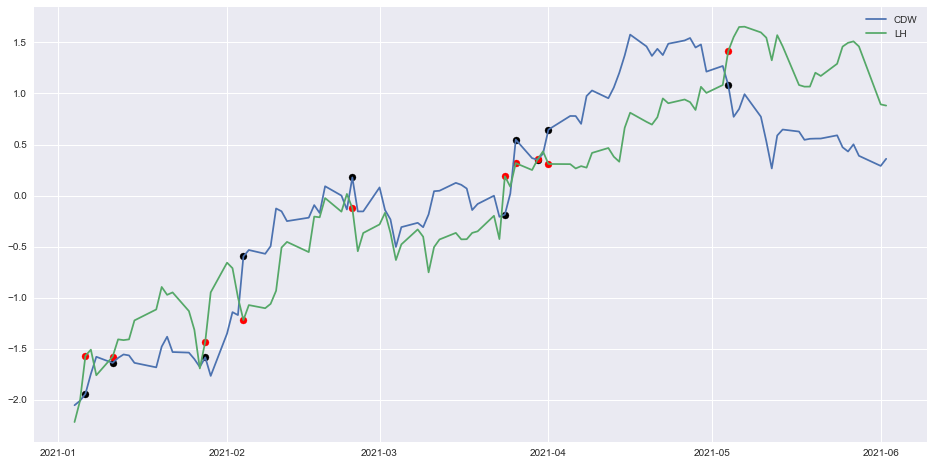

In [8]:
stock1, stock2 = 'CDW', 'LH'
plt.figure(figsize=(16,8))
plt.plot(normed[[stock1,stock2]])
plt.legend([stock1,stock2])
plt.scatter(cross_dates.index, cross_dates[stock1],c='k')
plt.scatter(cross_dates.index, cross_dates[stock2],c='r')

### Read options data and backtest

In [22]:
start_date = '20210104'
end_date = '20210602'
optionsdata = readMultiDay(DATA_DIR, start_date, end_date, ticker=['CDW', 'LH'])

20210104 done!
20210105 done!
20210106 done!
20210107 done!
20210108 done!
20210109 is not a trading day.
20210110 is not a trading day.
20210111 done!
20210112 done!
20210113 done!
20210114 done!
20210115 done!
20210116 is not a trading day.
20210117 is not a trading day.
20210118 is not a trading day.
20210119 done!
20210120 done!
20210121 done!
20210122 done!
20210123 is not a trading day.
20210124 is not a trading day.
20210125 done!
20210126 done!
20210127 done!
20210128 done!
20210129 done!
20210130 is not a trading day.
20210131 is not a trading day.
20210201 done!
20210202 done!
20210203 done!
20210204 done!
20210205 done!
20210206 is not a trading day.
20210207 is not a trading day.
20210208 done!
20210209 done!
20210210 done!
20210211 done!
20210212 done!
20210213 is not a trading day.
20210214 is not a trading day.
20210215 is not a trading day.
20210216 done!
20210217 done!
20210218 done!
20210219 done!
20210220 is not a trading day.
20210221 is not a trading day.
20210222 

In [16]:
optionsdata.head()

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte
0,CDW,127.56,CDW150121C070,call,2021-01-15,2021-01-04,70.0,57.61,55.0,60.0,0,0,1.40704,1.0,0.000000e+00,-0.004977,0.00001,11
1,CDW,127.56,CDW150121C075,call,2021-01-15,2021-01-04,75.0,52.62,50.0,55.0,0,0,1.27591,1.0,0.000000e+00,-0.005332,0.00001,11
2,CDW,127.56,CDW150121C080,call,2021-01-15,2021-01-04,80.0,47.62,45.0,50.0,0,0,1.15041,1.0,0.000000e+00,-0.005688,0.00001,11
3,CDW,127.56,CDW150121C085,call,2021-01-15,2021-01-04,85.0,42.63,40.0,45.0,0,0,1.03301,1.0,0.000000e+00,-0.006043,0.00001,11
4,CDW,127.56,CDW150121C090,call,2021-01-15,2021-01-04,90.0,37.63,35.0,40.0,0,0,0.92218,1.0,1.900000e-07,-0.006400,0.00001,11


In [18]:
index = (optionsdata['underlying']=='CDW') & (optionsdata['type']=='call') & \
        (optionsdata['delta']>0.5) & (optionsdata['quotedate'].isin(cross_dates.index))

In [19]:
filtered = optionsdata[index].reset_index(drop=True)

In [21]:
optionsdata['quotedate'].isin(cross_dates.index)

0      False
1      False
2      False
3      False
4      False
       ...  
617    False
618    False
619    False
620    False
621    False
Name: quotedate, Length: 1244, dtype: bool

In [23]:
legs = []
for stock in ['CDW','LH']:
    index = (optionsdata['underlying']==stock) & (optionsdata['type']=='call') & \
            (optionsdata['delta']>0.5) & (optionsdata['quotedate'].isin(cross_dates.index))
    filtered = optionsdata[index].reset_index(drop=True)
    filtered['sminusk'] = np.abs(filtered['underlying_last']-filtered['strike'])
    
    option_basket = []
    for date in cross_dates.index:
        option = filtered[filtered['quotedate']==date].sort_values(by=['dte','sminusk']).iloc[[0]]
        option_basket.append(option)
    option_basket = pd.concat(option_basket).reset_index(drop=True)
    legs.append(option_basket)

In [24]:
cross_dates

Symbols,CDW,LH,lower,cross_signal,true_cross,CDW_direction,LH_direction
Date,,,,,,,
2021-01-06,-1.943603,-1.570549,CDW,1.0,1.0,Direction.BUY,Direction.SELL
2021-01-11,-1.640180,-1.578480,CDW,1.0,1.0,Direction.BUY,Direction.SELL
2021-01-28,-1.585883,-1.430956,CDW,1.0,1.0,Direction.BUY,Direction.SELL
2021-02-04,-0.597043,-1.219979,LH,1.0,1.0,Direction.SELL,Direction.BUY
2021-02-24,0.177165,-0.124381,LH,1.0,1.0,Direction.SELL,Direction.BUY
2021-03-24,-0.186304,0.188646,CDW,1.0,1.0,Direction.BUY,Direction.SELL
2021-03-26,0.547660,0.317136,LH,1.0,1.0,Direction.SELL,Direction.BUY
2021-03-30,0.350915,0.353620,CDW,1.0,1.0,Direction.BUY,Direction.SELL
2021-04-01,0.646033,0.309204,LH,1.0,1.0,Direction.SELL,Direction.BUY


In [25]:
legs[0]

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte,sminusk
0,CDW,129.08,CDW150121C0125,call,2021-01-15,2021-01-06,125.0,5.69,4.8,7.0,3,9,0.38439,0.738755,0.043774,-0.166298,0.066331,9,4.08
1,CDW,133.68,CDW150121C0130,call,2021-01-15,2021-01-11,130.0,4.65,3.1,5.1,30,77,0.25028,0.763120,0.055133,-0.248429,0.043793,4,3.68
2,CDW,134.47,CDW190221C0135,call,2021-02-19,2021-01-28,135.0,4.84,4.6,5.0,0,54,0.38261,0.503698,0.030608,-0.119294,0.131845,22,0.53
3,CDW,148.88,CDW190221C0145,call,2021-02-19,2021-02-04,145.0,6.53,6.3,6.9,66,54,0.36289,0.658717,0.033920,-0.137756,0.111465,15,3.88
4,CDW,162.21,CDW190321C0160,call,2021-03-19,2021-02-24,160.0,6.56,6.3,6.7,16,118,0.33015,0.579645,0.027882,-0.120023,0.159497,23,2.21
5,CDW,157.26,CDW160421C0155,call,2021-04-16,2021-03-24,155.0,5.73,5.2,6.5,5,33,0.29264,0.597240,0.034550,-0.097305,0.151419,23,2.26
6,CDW,166.51,CDW160421C0165,call,2021-04-16,2021-03-26,165.0,5.18,4.8,5.3,10,40,0.27070,0.564117,0.035046,-0.104075,0.157079,21,1.51
7,CDW,165.09,CDW160421C0165,call,2021-04-16,2021-03-30,165.0,4.03,3.7,4.2,4,40,0.26941,0.521608,0.040361,-0.121028,0.141985,17,0.09
8,CDW,169.06,CDW160421C0165,call,2021-04-16,2021-04-01,165.0,5.67,5.5,5.9,4,40,0.24699,0.690467,0.041500,-0.097415,0.122580,15,4.06
9,CDW,175.99,CDW210521C0175,call,2021-05-21,2021-05-04,175.0,5.23,4.0,6.8,81,107,0.33191,0.538901,0.032922,-0.135028,0.150929,17,0.99


In [26]:
legs[1]

,underlying,underlying_last,optionroot,type,expiration,quotedate,strike,last,bid,ask,volume,openinterest,impliedvol,delta,gamma,theta,vega,dte,sminusk
0,LH,216.94,LH150121C0210,call,2021-01-15,2021-01-06,210.0,8.43,8.0,8.9,62,2295,0.29307,0.771639,0.030409,-0.179654,0.100240,9,6.94
1,LH,216.34,LH150121C0210,call,2021-01-15,2021-01-11,210.0,7.29,6.2,8.7,2,2263,0.28114,0.782243,0.036135,-0.281900,0.067523,4,6.34
2,LH,219.54,LH190221C0220,call,2021-02-19,2021-01-28,220.0,7.85,7.3,8.3,6,2887,0.36565,0.515125,0.020189,-0.187211,0.214984,22,0.46
3,LH,223.92,LH190221C0220,call,2021-02-19,2021-02-04,220.0,8.13,7.4,9.1,37,2883,0.33138,0.624015,0.025832,-0.195759,0.173411,15,3.92
4,LH,245.19,LH190321C0240,call,2021-03-19,2021-02-24,240.0,11.01,10.3,12.6,56,651,0.35073,0.620160,0.018720,-0.173478,0.234938,23,5.19
5,LH,251.13,LH160421C0250,call,2021-04-16,2021-03-24,250.0,7.34,6.6,8.2,309,385,0.26416,0.548697,0.023803,-0.152304,0.250254,23,1.13
6,LH,251.46,LH160421C0250,call,2021-04-16,2021-03-26,250.0,6.84,6.6,7.4,9,348,0.25924,0.548886,0.023595,-0.160514,0.239788,21,1.46
7,LH,253.58,LH160421C0250,call,2021-04-16,2021-03-30,250.0,7.51,6.4,7.9,11,374,0.23719,0.613121,0.027551,-0.158128,0.210332,17,3.58
8,LH,251.53,LH160421C0250,call,2021-04-16,2021-04-01,250.0,5.90,4.8,6.7,2,365,0.23554,0.568518,0.031836,-0.173863,0.200036,15,1.53
9,LH,272.68,LH210521C0270,call,2021-05-21,2021-05-04,270.0,6.45,4.6,7.1,20,478,0.19273,0.586079,0.030536,-0.140831,0.227236,17,2.68


In [27]:
options_data = HistoricalOptionsData(optionsdata)
options_schema = options_data.schema

In [28]:
data_end_date = pd.to_datetime('2021-5-18')
logs = []
inventory = []
pnl = []
value = []
for i, date in enumerate(cross_dates.index):
    option_strategy = Strategy(options_schema)

    leg1 = StrategyLeg('leg_1', options_schema, option_type=Type.CALL, direction=cross_dates.loc[date,'CDW_direction'])
    leg1.entry_filter = ((options_schema.contract == legs[0].loc[i,'optionroot']) &
                        (options_schema.dte == legs[0].loc[i,'dte'])) 
    if legs[0].loc[i,'expiration'] > data_end_date:
        leg1.exit_filter = (options_schema.dte == (legs[0].loc[i,'expiration'] - data_end_date).days)
    else:
        leg1.exit_filter = (options_schema.dte == 0) 

    leg2 = StrategyLeg('leg_2', options_schema, option_type=Type.CALL, direction=cross_dates.loc[date,'LH_direction'])
    leg2.entry_filter = ((options_schema.contract == legs[1].loc[i,'optionroot']) &
                        (options_schema.dte == legs[1].loc[i,'dte']))
    if legs[1].loc[i,'expiration'] > data_end_date:
        leg2.exit_filter = (options_schema.dte == (legs[1].loc[i,'expiration'] - data_end_date).days)
    else:
        leg2.exit_filter = (options_schema.dte == 0) 

    option_strategy.add_legs([leg1, leg2])

    bt = backtest(initial_capital=1_000_000)
    bt.options_strategy = option_strategy
    bt.options_data = options_data
    bt.open_close_type = ('mid', 'mid')
    notional = 1e6
    bt.options_qty = notional/legs[0].loc[i,'underlying_last']/100, notional/legs[1].loc[i,'underlying_last']/100

    trade_log, options_inventory, portfolio_pnl = bt.run()
    portfolio_value = bt.portfolio_value()
    logs.append(trade_log)
    inventory.append(options_inventory)
    pnl.append(portfolio_pnl)
    value.append(portfolio_value)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished


<BarContainer object of 10 artists>

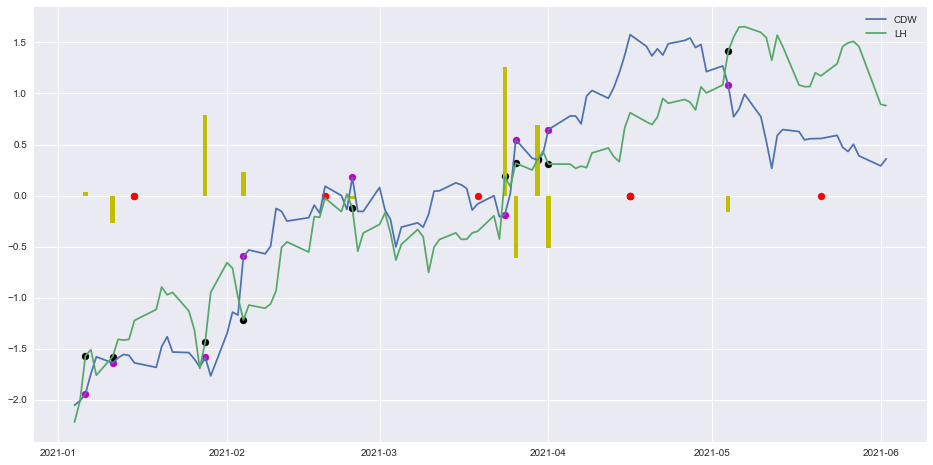

In [29]:
plt.figure(figsize=(16,8))
plt.plot(normed[[stock1,stock2]])
plt.legend([stock1,stock2])
plt.scatter(cross_dates.index, cross_dates[stock1],c='m')
plt.scatter(cross_dates.index, cross_dates[stock2],c='k')
plt.scatter(legs[0]['expiration'], [0]*10,c='r')
plt.bar(cross_dates.index, [-log['totals']['cost'].sum()/1000 for log in logs],color='y')

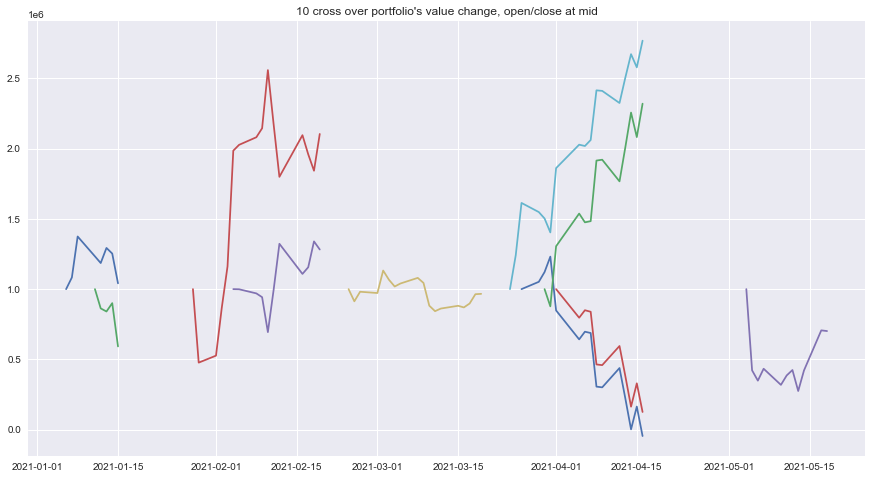

In [30]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("10 cross over portfolio's value change, open/close at mid")
for i in range(10):
    ax.plot(value[i])

In [31]:
pd.concat([log['totals'] for log in logs]).reset_index(drop=True)['cost'].sum()

-1430.6514147680782

In [32]:
#return for 10 portfolio
[round(v.iloc[-1]/1e6 -1, 2) for v in value]

[0.04, -0.41, 1.1, 0.28, -0.03, 1.77, -1.05, 1.32, -0.87, -0.3]

### Add exit threshold

In [33]:
data_end_date = pd.to_datetime('2021-5-18')
logs = []
inventory = []
pnl = []
value = []
for i, date in enumerate(cross_dates.index):
    option_strategy = Strategy(options_schema)

    leg1 = StrategyLeg('leg_1', options_schema, option_type=Type.CALL, direction=cross_dates.loc[date,'CDW_direction'])
    leg1.entry_filter = ((options_schema.contract == legs[0].loc[i,'optionroot']) &
                        (options_schema.dte == legs[0].loc[i,'dte'])) 
    if legs[0].loc[i,'expiration'] > data_end_date:
        leg1.exit_filter = (options_schema.dte == (legs[0].loc[i,'expiration'] - data_end_date).days)
    else:
        leg1.exit_filter = (options_schema.dte == 0) 

    leg2 = StrategyLeg('leg_2', options_schema, option_type=Type.CALL, direction=cross_dates.loc[date,'LH_direction'])
    leg2.entry_filter = ((options_schema.contract == legs[1].loc[i,'optionroot']) &
                        (options_schema.dte == legs[1].loc[i,'dte']))
    if legs[1].loc[i,'expiration'] > data_end_date:
        leg2.exit_filter = (options_schema.dte == (legs[1].loc[i,'expiration'] - data_end_date).days)
    else:
        leg2.exit_filter = (options_schema.dte == 0) 

    option_strategy.add_legs([leg1, leg2])

    bt = backtest(initial_capital=1_000_000)
    bt.options_strategy = option_strategy
    bt.options_data = options_data
    bt.open_close_type = ('mid', 'mid')
    bt.exit_thresholds = ((0.3,-0.1),(0.3,-0.1))
    notional = 1e6
    bt.options_qty = notional/legs[0].loc[i,'underlying_last']/100, notional/legs[1].loc[i,'underlying_last']/100

    trade_log, options_inventory, portfolio_pnl = bt.run()
    portfolio_value = bt.portfolio_value()
    logs.append(trade_log)
    inventory.append(options_inventory)
    pnl.append(portfolio_pnl)
    value.append(portfolio_value)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished


<BarContainer object of 10 artists>

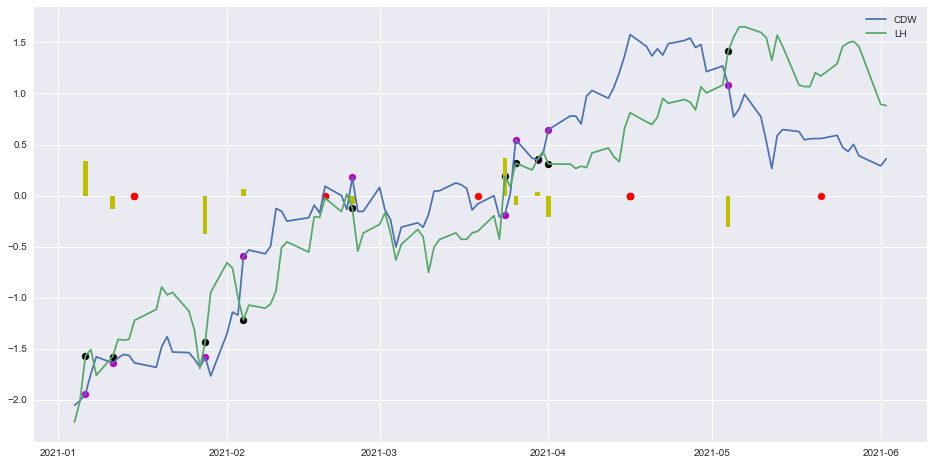

In [34]:
plt.figure(figsize=(16,8))
plt.plot(normed[[stock1,stock2]])
plt.legend([stock1,stock2])
plt.scatter(cross_dates.index, cross_dates[stock1],c='m')
plt.scatter(cross_dates.index, cross_dates[stock2],c='k')
plt.scatter(legs[0]['expiration'], [0]*10,c='r')
plt.bar(cross_dates.index, [-log['totals']['cost'].sum()/1000 for log in logs],color='y')

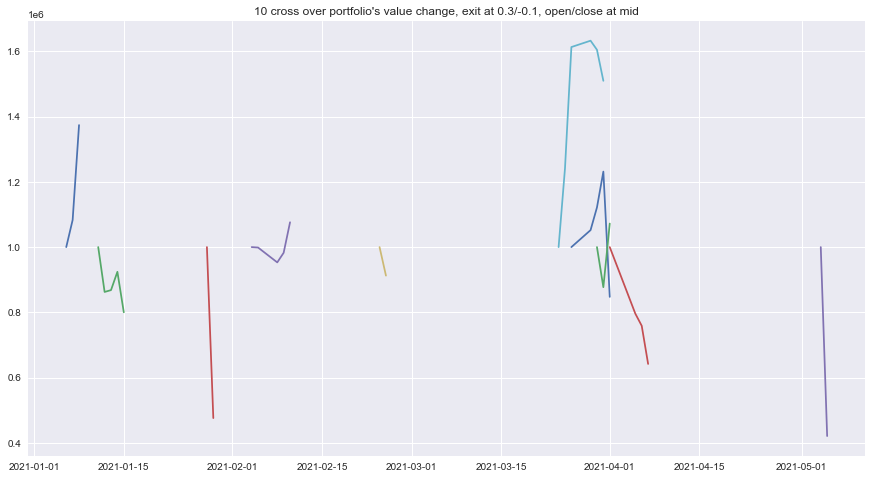

In [35]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("10 cross over portfolio's value change, exit at 0.3/-0.1, open/close at mid")
for i in range(10):
    ax.plot(value[i])

In [36]:
pd.concat([log['totals'] for log in logs]).reset_index(drop=True)['cost'].sum()

386.6386208920855

In [37]:
#return for 10 portfolio
[round(v.iloc[-1]/1e6 -1, 2) for v in value]

[0.37, -0.2, -0.52, 0.08, -0.09, 0.51, -0.15, 0.07, -0.36, -0.58]

### Smoothing

In [38]:
from scipy.signal import savgol_filter

In [39]:
smoothed = savgol_filter(normed[[stock1,stock2]].T,13,5).T
smoothed_df = pd.DataFrame(smoothed,columns=[stock1,stock2],index=normed.index)

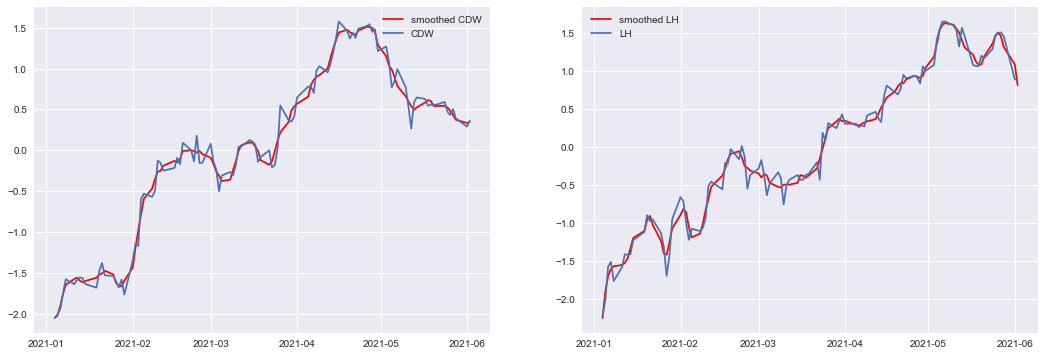

In [40]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
ax[0].plot(smoothed_df[stock1], 'r')
ax[0].plot(normed[stock1])
ax[0].legend(['smoothed '+stock1, stock1])

ax[1].plot(smoothed_df[stock2], 'r')
ax[1].plot(normed[stock2])
ax[1].legend(['smoothed '+stock2,stock2])

<AxesSubplot:title={'center':'smoothed stock price'}, xlabel='Date'>

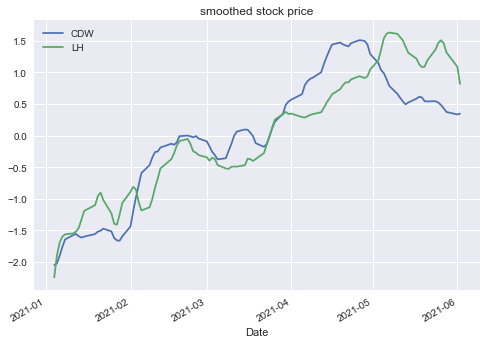

In [41]:
smoothed_df.plot(title='smoothed stock price')

In [42]:
smoothed_cross_signal = cross_over_signal(smoothed_df)

In [43]:
smoothed_cross_dates = smoothed_cross_signal[smoothed_cross_signal['cross_signal']==1]
smoothed_cross_dates['CDW_direction'] = smoothed_cross_dates.apply(lambda x: Direction.BUY if x['lower']=='CDW' else Direction.SELL, axis=1)
smoothed_cross_dates['LH_direction'] = ~smoothed_cross_dates['CDW_direction']
smoothed_cross_dates

,CDW,LH,lower,cross_signal,true_cross,CDW_direction,LH_direction
Date,,,,,,,
2021-01-05,-2.026276,-1.894472,CDW,1.0,1.0,Direction.BUY,Direction.SELL
2021-02-04,-0.786077,-1.054628,LH,1.0,1.0,Direction.SELL,Direction.BUY
2021-03-25,0.114645,0.122101,CDW,1.0,1.0,Direction.BUY,Direction.SELL
2021-03-29,0.346434,0.339209,LH,1.0,1.0,Direction.SELL,Direction.BUY
2021-05-03,1.149757,1.192505,CDW,1.0,1.0,Direction.BUY,Direction.SELL


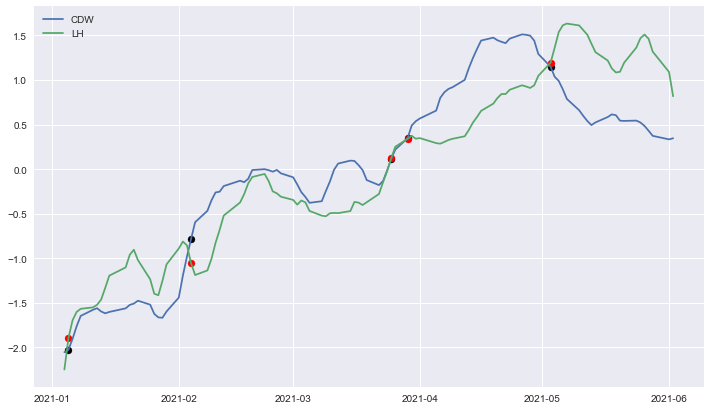

In [44]:
stock1, stock2 = 'CDW', 'LH'
plt.figure(figsize=(12,7))
plt.plot(smoothed_df[[stock1,stock2]])
plt.legend([stock1,stock2])
plt.scatter(smoothed_cross_dates.index, smoothed_cross_dates[stock1],c='k')
plt.scatter(smoothed_cross_dates.index, smoothed_cross_dates[stock2],c='r')

In [45]:
#get entry options for each leg
legs = []
for stock in ['CDW','LH']:
    index = (optionsdata['underlying']==stock) & (optionsdata['type']=='call') & \
            (optionsdata['delta']>0.5) & (optionsdata['quotedate'].isin(smoothed_cross_dates.index))
    filtered = optionsdata[index].reset_index(drop=True)
    filtered['sminusk'] = np.abs(filtered['underlying_last']-filtered['strike'])
    
    option_basket = []
    for date in smoothed_cross_dates.index:
        option = filtered[filtered['quotedate']==date].sort_values(by=['dte','sminusk']).iloc[[0]]
        option_basket.append(option)
    option_basket = pd.concat(option_basket).reset_index(drop=True)
    legs.append(option_basket)

In [46]:
data_end_date = pd.to_datetime('2021-5-18')
logs = []
inventory = []
pnl = []
value = []
for i, date in enumerate(smoothed_cross_dates.index):
    option_strategy = Strategy(options_schema)

    leg1 = StrategyLeg('leg_1', options_schema, option_type=Type.CALL, direction=smoothed_cross_dates.loc[date,'CDW_direction'])
    leg1.entry_filter = ((options_schema.contract == legs[0].loc[i,'optionroot']) &
                        (options_schema.dte == legs[0].loc[i,'dte'])) 
    if legs[0].loc[i,'expiration'] > data_end_date:
        leg1.exit_filter = (options_schema.dte == (legs[0].loc[i,'expiration'] - data_end_date).days)
    else:
        leg1.exit_filter = (options_schema.dte == 0) 

    leg2 = StrategyLeg('leg_2', options_schema, option_type=Type.CALL, direction=smoothed_cross_dates.loc[date,'LH_direction'])
    leg2.entry_filter = ((options_schema.contract == legs[1].loc[i,'optionroot']) &
                        (options_schema.dte == legs[1].loc[i,'dte']))
    if legs[1].loc[i,'expiration'] > data_end_date:
        leg2.exit_filter = (options_schema.dte == (legs[1].loc[i,'expiration'] - data_end_date).days)
    else:
        leg2.exit_filter = (options_schema.dte == 0) 

    option_strategy.add_legs([leg1, leg2])

    bt = backtest(initial_capital=1_000_000)
    bt.options_strategy = option_strategy
    bt.options_data = options_data
    bt.open_close_type = ('mid', 'mid')
    notional = 1e6
    bt.options_qty = notional/legs[0].loc[i,'underlying_last']/100, notional/legs[1].loc[i,'underlying_last']/100

    trade_log, options_inventory, portfolio_pnl = bt.run()
    portfolio_value = bt.portfolio_value()
    logs.append(trade_log)
    inventory.append(options_inventory)
    pnl.append(portfolio_pnl)
    value.append(portfolio_value)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished


<BarContainer object of 5 artists>

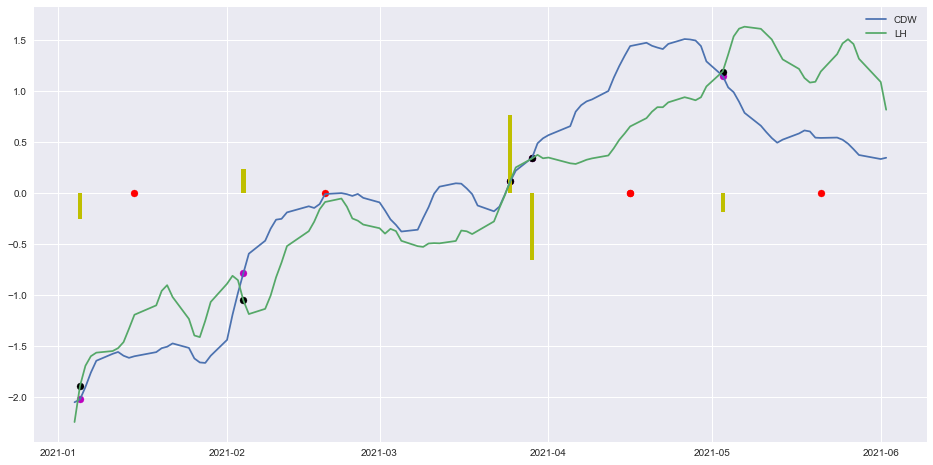

In [47]:
plt.figure(figsize=(16,8))
plt.plot(smoothed_df[[stock1,stock2]])
plt.legend([stock1,stock2])
plt.scatter(smoothed_cross_dates.index, smoothed_cross_dates[stock1],c='m')
plt.scatter(smoothed_cross_dates.index, smoothed_cross_dates[stock2],c='k')
plt.scatter(legs[0]['expiration'], [0]*5,c='r')
plt.bar(smoothed_cross_dates.index, [-log['totals']['cost'].sum()/1000 for log in logs],color='y')

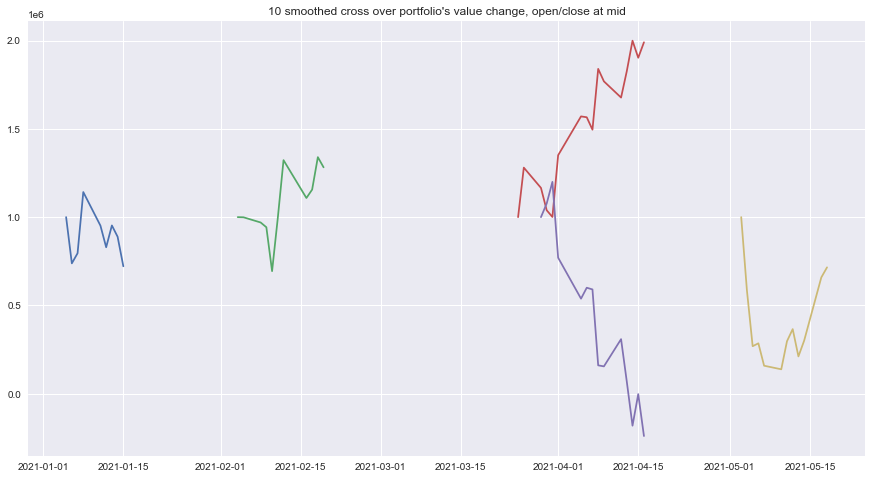

In [48]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("10 smoothed cross over portfolio's value change, open/close at mid")
for i in range(5):
    ax.plot(value[i])

In [49]:
pd.concat([log['totals'] for log in logs]).reset_index(drop=True)['cost'].sum()

98.54614223662674

In [50]:
#return for 10 portfolio
[round(v.iloc[-1]/1e6 -1, 2) for v in value]

[-0.28, 0.28, 0.99, -1.24, -0.28]

In [ ]:
smoothed_cross_dates = smoothed_cross_signal[smoothed_cross_signal['cross_signal']==1]
smoothed_cross_dates['CDW_direction'] = smoothed_cross_dates.apply(lambda x: Direction.SELL if x['lower']=='CDW' else Direction.BUY, axis=1)
smoothed_cross_dates['LH_direction'] = ~smoothed_cross_dates['CDW_direction']
smoothed_cross_dates

In [51]:
data_end_date = pd.to_datetime('2021-5-18')
logs = []
inventory = []
pnl = []
value = []
for i, date in enumerate(smoothed_cross_dates.index):
    option_strategy = Strategy(options_schema)

    leg1 = StrategyLeg('leg_1', options_schema, option_type=Type.CALL, direction=smoothed_cross_dates.loc[date,'CDW_direction'])
    leg1.entry_filter = ((options_schema.contract == legs[0].loc[i,'optionroot']) &
                        (options_schema.dte == legs[0].loc[i,'dte'])) 
    if legs[0].loc[i,'expiration'] > data_end_date:
        leg1.exit_filter = (options_schema.dte == (legs[0].loc[i,'expiration'] - data_end_date).days)
    else:
        leg1.exit_filter = (options_schema.dte == 0) 

    leg2 = StrategyLeg('leg_2', options_schema, option_type=Type.CALL, direction=smoothed_cross_dates.loc[date,'LH_direction'])
    leg2.entry_filter = ((options_schema.contract == legs[1].loc[i,'optionroot']) &
                        (options_schema.dte == legs[1].loc[i,'dte']))
    if legs[1].loc[i,'expiration'] > data_end_date:
        leg2.exit_filter = (options_schema.dte == (legs[1].loc[i,'expiration'] - data_end_date).days)
    else:
        leg2.exit_filter = (options_schema.dte == 0) 

    option_strategy.add_legs([leg1, leg2])

    bt = backtest(initial_capital=1_000_000)
    bt.options_strategy = option_strategy
    bt.options_data = options_data
    bt.open_close_type = ('mid', 'mid')
    notional = 1e6
    bt.options_qty = notional/legs[0].loc[i,'underlying_last']/100, notional/legs[1].loc[i,'underlying_last']/100

    trade_log, options_inventory, portfolio_pnl = bt.run()
    portfolio_value = bt.portfolio_value()
    logs.append(trade_log)
    inventory.append(options_inventory)
    pnl.append(portfolio_pnl)
    value.append(portfolio_value)
    print(f'{i} finished')

0 finished
1 finished
2 finished
3 finished
4 finished


<BarContainer object of 5 artists>

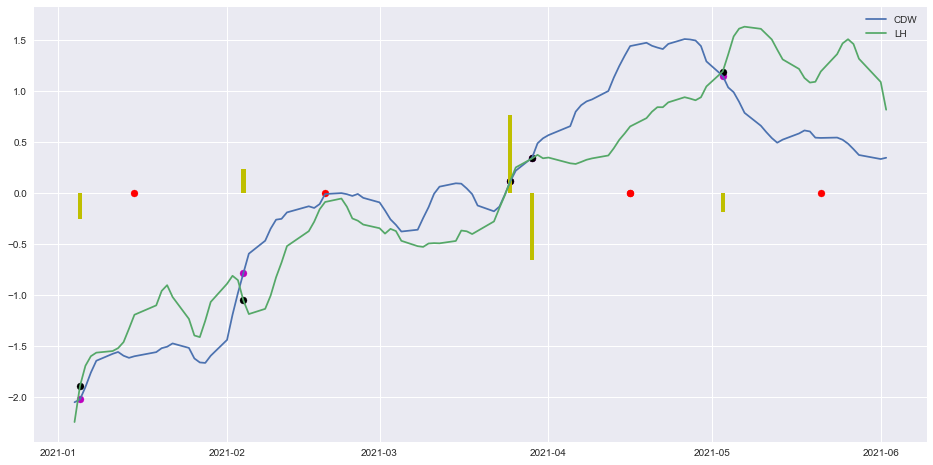

In [52]:
plt.figure(figsize=(16,8))
plt.plot(smoothed_df[[stock1,stock2]])
plt.legend([stock1,stock2])
plt.scatter(smoothed_cross_dates.index, smoothed_cross_dates[stock1],c='m')
plt.scatter(smoothed_cross_dates.index, smoothed_cross_dates[stock2],c='k')
plt.scatter(legs[0]['expiration'], [0]*5,c='r')
plt.bar(smoothed_cross_dates.index, [-log['totals']['cost'].sum()/1000 for log in logs],color='y')

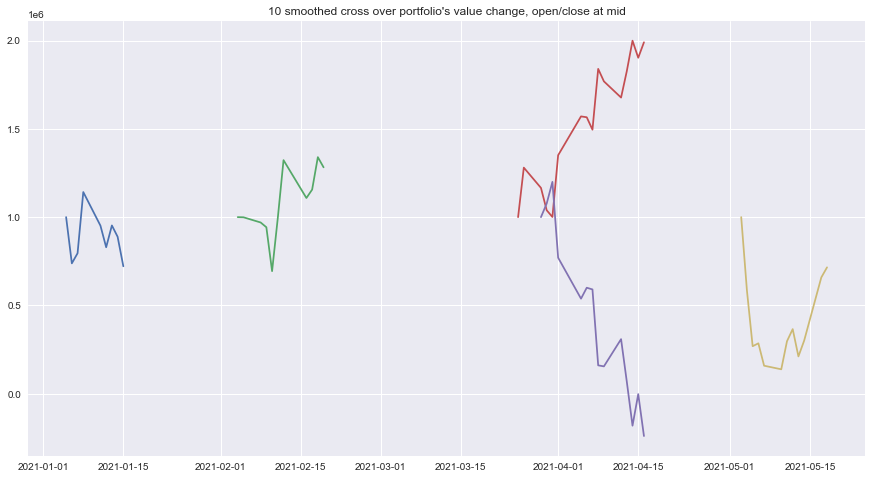

In [53]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title("10 smoothed cross over portfolio's value change, open/close at mid")
for i in range(5):
    ax.plot(value[i])